In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu
from transformers import XLNetConfig, AutoConfig
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from torchsummary import summary
from tensorboard.plugins import projector
from scipy.optimize import linear_sum_assignment
from utils.utils import *
from utils.assignment import *
from utils.latent_loss import *
from model.model import *

# Set Cuda

In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# DataSet & DataLoader

In [3]:
tokenizer = ByteLevelBPETokenizer(
    os.path.abspath(os.path.join('tokenizer','vocab.json')),
    os.path.abspath(os.path.join('tokenizer','merges.txt'))
)

tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
print(tokenizer.encode('the cardiac silhouette and mediastinum size are within normal limits').ids)
print(tokenizer.decode([1, 267, 650, 465, 317, 695, 424, 299, 426, 360, 476, 2]))

[1, 267, 650, 465, 317, 695, 424, 299, 426, 360, 476, 2]
<s>the cardiac silhouette and mediastinum size are within normal limits</s>


In [4]:
class XRayDataset(Dataset):
    def __init__(self, data, img_dir, transform, max_sentence, tokenizer, max_t): ## add max_sentence
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        self.max_sentence = max_sentence
        self.max_t = max_t
        self.sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).resize((256, 256))
        label = self.data.iloc[idx, 2]
        
        image = transform_img(image, self.transform)
        _, label = tokenize_report(label)
        if '' in label:
            label.remove('')
        
        embedding = self.sbert.encode(label)
        embedding = torch.tensor(embedding)
        
        id_ = torch.zeros((self.max_sentence, self.max_t)).long()
        for i, sent in enumerate(label):
            input_ids = self.tokenizer.encode(sent).ids
            for j, word in enumerate(input_ids):
                id_[i, j] = word
        
        len_ = len(label)
        len_ = torch.tensor(len_, dtype=torch.int32)
        
        embedding = F.pad(embedding, (0, 0, 0, self.max_sentence-len_), value=-1)
        
        return image[0], embedding, id_, len_

In [5]:
df_train = pd.read_csv('data/train_clean.csv')
df_test = pd.read_csv('data/testing_set.csv')

df_train = df_train[np.logical_not(df_train.Findings == 'startseq  endseq')]
df_test = df_test[np.logical_not(df_test.Findings == 'startseq  endseq')]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

img_path = 'data/images'
max_sentence = 18
max_t = 60

transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

tokenizer = ByteLevelBPETokenizer(
    os.path.abspath(os.path.join('tokenizer','vocab.json')),
    os.path.abspath(os.path.join('tokenizer','merges.txt'))
)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)

vocab_size = len(tokenizer.get_vocab())

In [6]:
train_data = XRayDataset(df_train, img_path, transform, max_sentence, tokenizer, max_t)
test_data = XRayDataset(df_test, img_path, transform, max_sentence, tokenizer, max_t)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [7]:
for i, data in enumerate(train_loader):
    if i < 3:
        print(data[-2].shape)

torch.Size([16, 18, 60])
torch.Size([16, 18, 60])
torch.Size([16, 18, 60])


# Model

In [8]:
class SetPredictLSP(nn.Module):
    def __init__(self, device, hidden_dim=384, nhead=4, nlayers=3, max_sentence=18, vocab_size=3160, pad_token_id=0, max_t=60, dropout=0.4):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.cnn_text = CNN_Text(device=device)
        self.hungarian = MSEGCRLatentLoss()
        
        self.decoder = LSPDecoder(vocab_size = vocab_size, pad_token_id=pad_token_id, max_t=max_t, dropout=dropout)
        
        self.mlp = MLP().to(device)
        self.mlp.load_state_dict(torch.load('model/weights/length_model_best.pt'))
        
        self.max_t = max_sentence
        
    def forward(self, X, y, len_y, input_id, labels):
        '''
        X is image (bs, 3, H, W)
        R's shape is (bs, length, hidden_dim)
        feat will be use for the transformer decoder
        '''
        bs = X.shape[0]
        R, feat = self.cnn_text(X) 
        
        R = flat_by_lengths(R, (torch.ones((bs))*20).to(device))
        y = flat_by_lengths_max_t(y, len_y, self.max_t)
        R_pi, R_i, hung_loss = self.hungarian.forward(y, len_y, R, (torch.ones(bs, dtype=int)*20).to(device))
        
        context_series = expand_by_lengths(feat, len_y)
        ce_loss, logit = self.decoder(input_id, R_pi, context_series, labels)
        
        return logit, ce_loss, hung_loss
    
    def predict(self, X):
        R, feat = self.cnn_text(X) 
        len_R = self.mlp(X)
        len_R = torch.round(len_R).flatten()
        
        R = self.transformer_decoder(R.transpose(0, 1), feat).transpose(0, 1)
        R = flat_by_lengths_max_t(R, len_R, 20)
        x = self.linear(R)
        output = self.output(x)
        
        return output, len_R

In [48]:
model = SetPredictLSP(device).to(device)

params_to_update = model.parameters()

# print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
#         print("\t",name)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, min_lr=0.000001)

In [49]:
def train(train_loader):
    model.train()
    c=0
    correct=0
    hung = 0
    for X, y, id_, len_y in train_loader:  # Iterate in batches over the training dataset.
        label = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
        input_id = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
        out, ce_loss, hung_loss = model(X.to(device), y.to(device), len_y.to(device), input_id, label)
    
        total_loss = ce_loss + hung_loss
        total_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        loss = ce_loss # Compute the loss.
        c=c+1
        correct+=loss.cpu().detach().numpy()
        hung+=hung_loss.cpu().detach().numpy()
    return correct/c, hung/c

def test(loader):
    model.eval()
    correct = 0
    hung = 0
    c=0
    for X, y, id_, len_y in loader:  # Iterate in batches over the training/test dataset.
        label = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
        input_id = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
        out, ce_loss, hung_loss = model(X.to(device), y.to(device), len_y.to(device), input_id, label)
    
        correct += ce_loss.cpu().detach().numpy()  # Check against ground-truth labels.
        hung+=hung_loss.cpu().detach().numpy()
        c=c+1
    return correct / c, hung/c # Derive ratio of correct predictions.

In [50]:
train_loss = []
val_loss = []
test_loss = []
epochs = 30
min_loss = 100
print('start train')

for epoch in range(epochs):
    train_acc, hung_train = train(train_loader)
    test_acc, hung_test= test(test_loader)
    train_loss.append((train_acc, hung_train))
    test_loss.append((test_acc, hung_test))
#     scheduler.step(test_acc)
    print(f'Epoch: {epoch+1:03d}, Train CrossEntropy: {train_acc:.4f}, Test CrossEntropy: {test_acc:.4f}, Hung: {hung_train:.4f}, {hung_test:.4f}')
    if min_loss > test_acc:
        min_loss = test_acc
        print('Minimum Loss: {}'.format(min_loss))
        torch.save(model.state_dict(), "model/weights/SetPredict_ver4.pt")

start train
Epoch: 001, Train CrossEntropy: 3.3203, Test CrossEntropy: 2.2739, Hung: 0.6787, 0.5171
Minimum Loss: 2.2738979525036283
Epoch: 002, Train CrossEntropy: 2.2915, Test CrossEntropy: 2.0286, Hung: 0.3847, 0.2563
Minimum Loss: 2.028577853132177
Epoch: 003, Train CrossEntropy: 2.1043, Test CrossEntropy: 1.8363, Hung: 0.1798, 0.1300
Minimum Loss: 1.8362502875151459
Epoch: 004, Train CrossEntropy: 1.9749, Test CrossEntropy: 1.7337, Hung: 0.1185, 0.1106
Minimum Loss: 1.733694800624141
Epoch: 005, Train CrossEntropy: 1.8903, Test CrossEntropy: 1.6854, Hung: 0.1098, 0.1083
Minimum Loss: 1.6854215418850933
Epoch: 006, Train CrossEntropy: 1.8274, Test CrossEntropy: 1.5998, Hung: 0.1082, 0.1059
Minimum Loss: 1.5997518212706954
Epoch: 007, Train CrossEntropy: 1.7741, Test CrossEntropy: 1.5345, Hung: 0.1072, 0.1049
Minimum Loss: 1.534488360087077
Epoch: 008, Train CrossEntropy: 1.7238, Test CrossEntropy: 1.5436, Hung: 0.1061, 0.1050
Epoch: 009, Train CrossEntropy: 1.6893, Test CrossEntrop

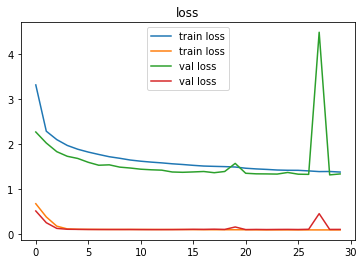

In [51]:
plt.title('loss')
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='val loss')

plt.legend()
plt.show()

In [52]:
train_loss_np = np.array(train_loss)
test_loss_np = np.array(test_loss)

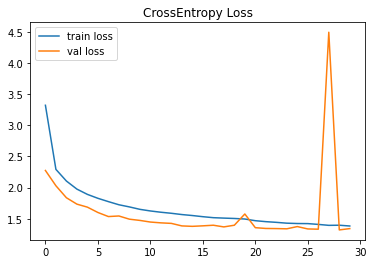

In [53]:
plt.title('CrossEntropy Loss')
plt.plot(np.arange(epochs), train_loss_np[:, 0], label='train loss')
plt.plot(np.arange(epochs), test_loss_np[:, 0], label='val loss')

plt.legend()
plt.show()

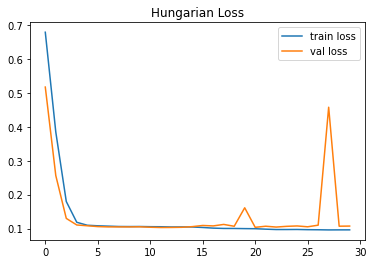

In [54]:
plt.title('Hungarian Loss')
plt.plot(np.arange(epochs), train_loss_np[:, 1], label='train loss')
plt.plot(np.arange(epochs), test_loss_np[:, 1], label='val loss')

plt.legend()
plt.show()

In [55]:
torch.save(model.state_dict(), "model/weights/SetPredict_last4.pt")

# Inference

In [9]:
model = SetPredictLSP(device).to(device)

model.eval()
print()

In [10]:
model.load_state_dict(torch.load('model/weights/SetPredict_ver3.pt'))

<All keys matched successfully>

In [25]:
df_train = pd.read_csv('data/training_set.csv')
df_test = pd.read_csv('data/testing_set.csv')

img_path = 'data/images'
max_sentence = 18

transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

encoder = pickle.load(open('data/sentence_encoder.pkl', 'rb'))
decoder = pickle.load(open('data/sentence_decoder.pkl', 'rb'))

In [26]:
train_data = XRayDataset(df_train, img_path, transform, max_sentence, encoder)
test_data = XRayDataset(df_test, img_path, transform, max_sentence, encoder)
train_loader = DataLoader(train_data, batch_size=81, shuffle=False)
test_loader = DataLoader(test_data, batch_size=81, shuffle=False)

In [11]:
actual_train = []
predicted_train = []
R = []
for X, y, id_, len_y in test_loader:  # Iterate in batches over the training/test dataset.
    label = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
    input_id = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18)
    out, ce_loss, hung_loss = model(X.to(device), y.to(device), len_y.to(device), input_id, label)
#     R_pi = flat_by_lengths(R_pi, len_y.to(device))
    
    actual_train.append(label.cpu().detach().numpy())
    predicted_train.append(out.cpu().detach().numpy())
#     R.append(R_pi.cpu().detach().numpy())

In [12]:
predicted_train[0].argmax(axis=-1)[1]

array([267, 286, 332, 334, 636,   2, 917, 479, 479,   2, 573,   2,   2,
         2,   2,   2,   2,   2,   2, 300,   2, 270,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2, 557, 557,   2,
       666, 557, 291, 703, 557, 917,   2, 300, 557,   2,   2, 300,   2,
         2, 506,   2, 917,   2,   2, 291, 557], dtype=int64)

In [63]:
id_ = 4

print(tokenizer.decode(predicted_train.argmax(axis=-1)[id_]))
print()
print(tokenizer.decode(actual_train[id_]))

the is been interval placement of multiple healed left rib fractures</s>ation</s></s></s></s></s>k</s></s> does</s></s></s></s></s> of</s> nodular</s></s></s></s> a</s></s> fractures and scan</s></s> of</s> correlate on</s> of</s></s></s>anc</s></s> xxxx</s></s></s></s>

<s>there has been interval development of multiple healed left rib fractures</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [13]:
predicted_train = np.concatenate(predicted_train)
actual_train = np.concatenate(actual_train)
# R = np.concatenate(R)

In [14]:
predicted_train.shape

(1937, 60, 3160)

In [15]:
predicted_train.argmax(axis=-1)

array([[ 267,  527,  299, ...,    2,    2,  269],
       [ 267,  286,  332, ...,    2,  291,  557],
       [ 267,  527,  465, ...,    2, 1568,  557],
       ...,
       [ 267, 2041,  857, ...,    2, 1224,  863],
       [ 267,  286,  815, ...,    2,    2,    2],
       [ 267,  527,  300, ...,    2,    2,    2]], dtype=int64)

In [20]:
id_ = 4

ref = actual_train[id_]
cad = predicted_train.argmax(axis=-1)[id_]

ref_eos = np.argwhere(ref==2).min()
cad_eos = np.argwhere(cad==2).min()

ref_sent = tokenizer.decode(ref[1: ref_eos])
cad_sent = tokenizer.decode(cad[0: cad_eos])

print("Actual Sentence: {}".format(ref_sent))
print("Predicted Sentence: {}".format(cad_sent))

score = sentence_bleu([ref_sent.split()], cad_sent.split())
print(score)

Actual Sentence: no focal consolidation pleural effusion or pneumothorax identified
Predicted Sentence: the focal consolidation pleural effusion or pneumothorax identified
0.8408964152537145


In [93]:
scores1 = []
scores2 = []
for id_ in range(predicted_train.shape[0]):
    ref = actual_train[id_]
    cad = predicted_train.argmax(axis=-1)[id_]

    ref_eos = np.argwhere(ref==2).min()
    cad_eos = np.argwhere(cad==2).min()

    ref_sent = tokenizer.decode(ref[1: ref_eos])
    cad_sent = tokenizer.decode(cad[0: cad_eos])

    score1 = sentence_bleu([ref_sent.split()], cad_sent.split())
    score2 = sentence_bleu([cad_sent.split()], ref_sent.split())
    scores1.append(score1)
    scores2.append(score2)

In [96]:
print(np.array(scores1).mean())
print(np.array(scores2).mean())

0.1729825633391337
0.17277915419960327


# Latent Space

In [ ]:
model.output = nn.Sequential(*list(model.output.children())[:-1])
model.eval()
model.to(device)

In [43]:
latent_space = []
check_label = []
for X, y, id_, len_y in train_loader:  # Iterate in batches over the training/test dataset.
    out, hung_loss = model(X.to(device), y.to(device), len_y.to(device))
    
    label = flat_by_lengths_max_t(id_.to(device), len_y.to(device), 18).cpu().detach().numpy()
    latent_space.append(out.cpu().detach().numpy())
    check_label.append(label)

In [44]:
latent_space = np.concatenate(latent_space)
check_label = np.concatenate(check_label)

In [45]:
latent_space.shape

(28844, 128)

In [53]:
np.argmax(predicted_train_np, axis=1)

(28844,)

In [55]:
latent_space

array([[-0.5426403 ,  0.50835794, -0.7050254 , ...,  0.26239976,
        -0.6147091 ,  0.24323207],
       [-0.54264027,  0.50835776, -0.70502543, ...,  0.26239976,
        -0.61470914,  0.24323201],
       [-0.5426403 ,  0.5083579 , -0.70502543, ...,  0.2623997 ,
        -0.6147091 ,  0.24323204],
       ...,
       [-0.5426423 ,  0.50835866, -0.70502394, ...,  0.26239997,
        -0.6147085 ,  0.24323077],
       [-0.54264235,  0.50835884, -0.70502406, ...,  0.26239988,
        -0.6147084 ,  0.24323067],
       [-0.54264235,  0.5083588 , -0.70502406, ...,  0.26239994,
        -0.6147085 ,  0.24323079]], dtype=float32)

In [54]:
predicted_train_np

array([[-0.72307193, -0.08381996,  0.7823553 , ..., -3.9740217 ,
        -3.860746  , -4.19671   ],
       [-0.7230718 , -0.08381993,  0.78235525, ..., -3.9740217 ,
        -3.8607454 , -4.19671   ],
       [-0.72307193, -0.08381993,  0.78235525, ..., -3.9740214 ,
        -3.8607457 , -4.1967106 ],
       ...,
       [-0.7230713 , -0.08382021,  0.78235614, ..., -3.9740212 ,
        -3.8607473 , -4.19671   ],
       [-0.7230712 , -0.08382021,  0.782356  , ..., -3.9740214 ,
        -3.8607466 , -4.1967096 ],
       [-0.7230714 , -0.08382018,  0.7823563 , ..., -3.9740217 ,
        -3.8607476 , -4.1967106 ]], dtype=float32)

In [ ]:
metadata_dict = {}
metadata_dict['label'] = label
metadata_dict['error'] = error